<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Prophet_Coal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.모듈 불러오기**








In [9]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_components_plotly


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **2.data**


In [87]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv", encoding = 'utf-8-sig')
df = df.sort_values('ds')
df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2019-04-01']
# df = df.reset_index()
df

,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,CAD_dollor,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
ds,,,,,,,,,,,,,,,,,,,,,
2011-01-01,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-02,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,0.99960,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2011-01-03,136.50,170.00,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,0.99270,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
2011-01-04,137.30,172.10,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,0.99239,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
2011-01-05,130.65,174.50,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,0.99700,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-27,93.50,85.72,67.83,6336.00,59.41,59.12,37.47,690.0,1.40115,1.33791,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
2019-03-28,92.95,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,1.34117,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
2019-03-29,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,1.34305,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


#산점도

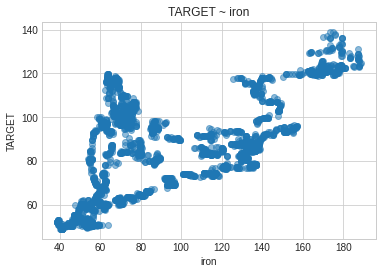

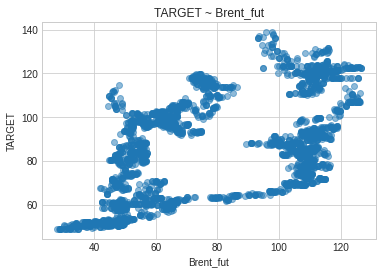

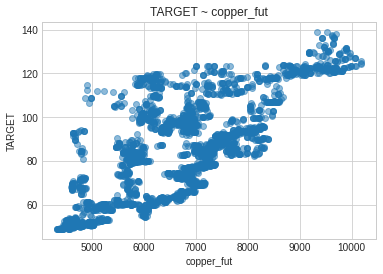

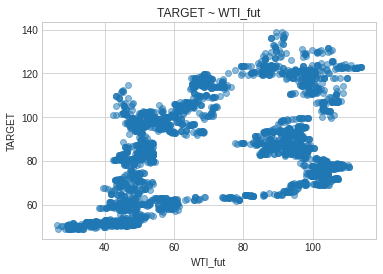

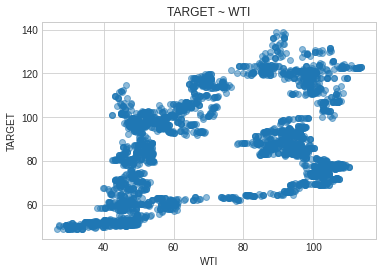

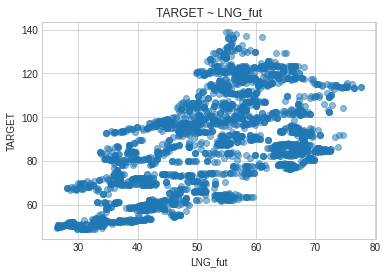

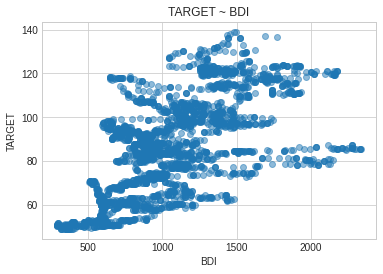

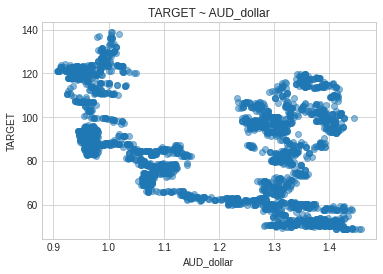

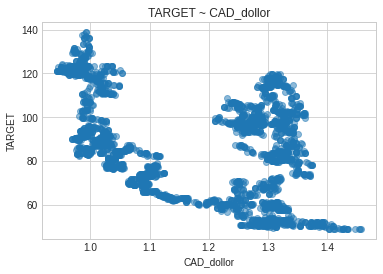

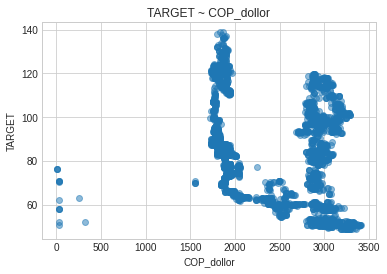

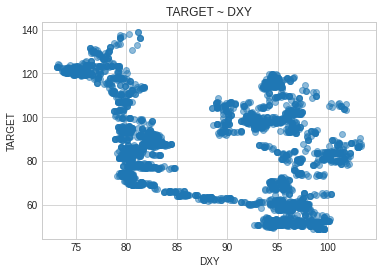

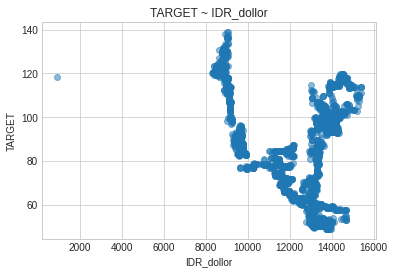

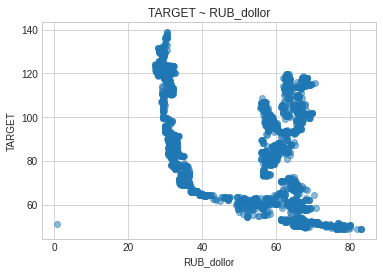

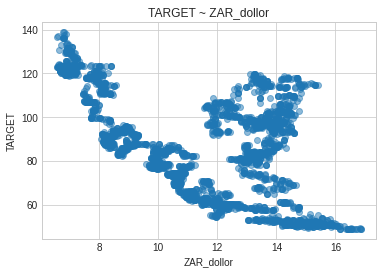

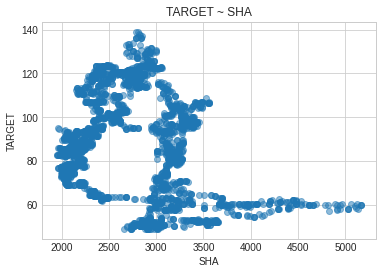

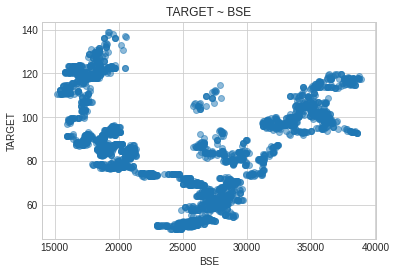

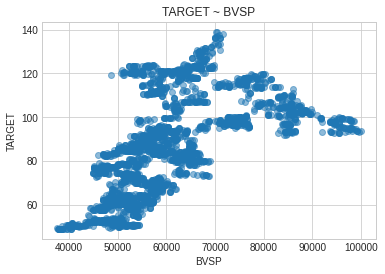

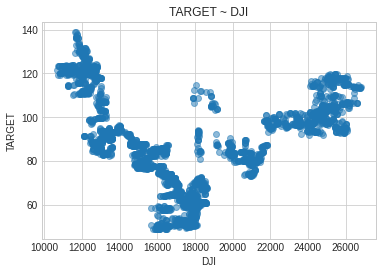

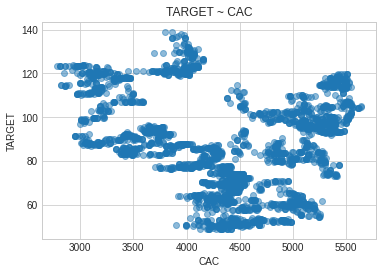

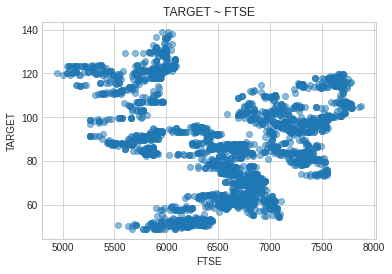

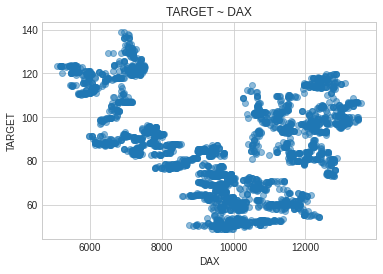

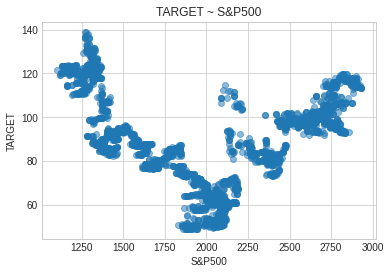

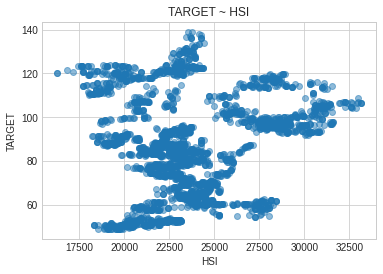

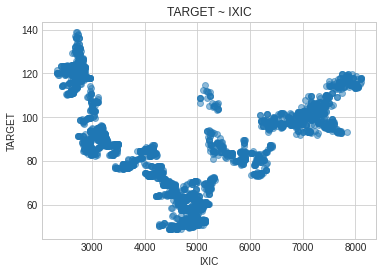

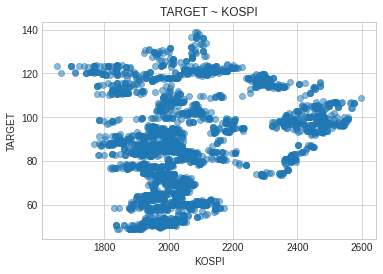

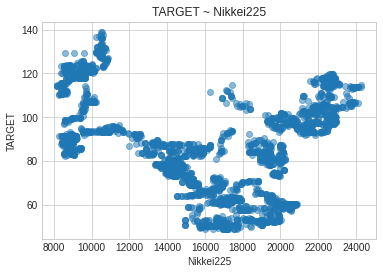

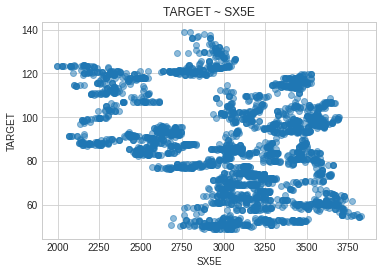

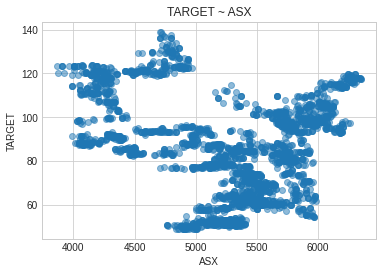

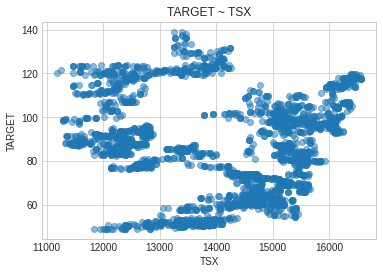

In [42]:
for i in range(1,len(df.columns)):
    X = df.iloc[:,i].values
    Y = df.iloc[:,0].values


    plt.scatter(X, Y, alpha=0.5)
    plt.title(f'TARGET ~ {df.iloc[:,i].name}')
    plt.xlabel(f'{df.iloc[:,i].name}')
    plt.ylabel('TARGET')
    plt.show()

#공분산 및 상관계수

In [89]:
for i in range(1,len(df.columns)):
 X = df.iloc[:,i].values
 Y = df.iloc[:,0].values


 p = np.corrcoef(X,Y)[0,1]
 print(f'{df.iloc[:,i].name} corrcoef is {p}')

iron corrcoef is 0.6222855901916815
Brent_fut corrcoef is 0.5045741890853804
copper_fut corrcoef is 0.7235394198123951
WTI_fut corrcoef is 0.44903765550885544
WTI corrcoef is 0.4496640500696631
LNG_fut corrcoef is 0.5897212025792706
BDI corrcoef is 0.602692771252653
AUD_dollar corrcoef is -0.4232454521760248
CAD_dollor corrcoef is -0.4083519117119885
COP_dollor corrcoef is -0.25995877668810635
DXY corrcoef is -0.451340297783814
IDR_dollor corrcoef is -0.4220283696368407
RUB_dollor corrcoef is -0.39982252847167093
ZAR_dollor corrcoef is -0.5209480157195969
SHA corrcoef is -0.23038497353490284
BSE corrcoef is -0.12228813412156363
BVSP corrcoef is 0.5814535444591438
DJI corrcoef is -0.05360393322145809
CAC corrcoef is -0.19739478997713863
FTSE corrcoef is -0.10417070475078617
DAX corrcoef is -0.2809257721011231
S&P500 corrcoef is -0.16784651056388564
HSI corrcoef is 0.14997404140287826
IXIC corrcoef is -0.08613431199275191
KOSPI corrcoef is 0.24513812714749247
Nikkei225 corrcoef is -0.281